<a href="https://colab.research.google.com/github/kritp03/SC1015-Mini-Project/blob/main/SC1015_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<h1 style = "font-size:40px; font-family:luxury; font-weight:bold; text-align:center; border-radius:10px 15px;">SC1015 Mini Project: Emotion Detection using CNN and ResNet 🙂🙁</h1>
<h3 style="font-family:luxury; text-align:center;">Contributors: Ponyuenyong Kritchanat, Sih Jia Qi, Tee Wei Ping</h3>
<h3 style="font-family:luxury; text-align:center;">Class: FCS7</h3>

<br>

---

## Problem Statement
In educational settings, it's crucial to comprehend and address students' emotional reactions during learning activities to enhance their learning experiences. To accomplish this goal, our team will develop a deep learning model that can accurately classify facial expressions into one of the eight categories: Neutral, Sad, Happy, Surprise, Angry, Fear, Contempt and Disgust. We will use the convolutional neural network (CNNs) to train our model on the FER-2013 and FERPLUS datasets.

By gaining insights into how students react emotionally to different learning activities, educators can tailor instructional strategies and interventions to better meet the needs of individual students.

<p align="center"><img src='assets/emotion_image.png'/></p>


## Datasets Used
>**Dataset 1: FER-2013 Dataset**

The FER2013 dataset is a facial expression recognition dataset consisting of 30,000 grayscale images of faces. The images are labeled with one of seven emotions: angry, disgust, fear, happy, sad, surprise, or neutral as shown in the table below.

| Label | Emotion |
| --- | --- |
| 0 | Angry |
| 1 | Disgust |
| 2 | Fear |
| 3 | Happy |
| 4 | Sad |
| 5 | Surprise |
| 6 | Neutral |

The FER2013 dataset is a challenging dataset for facial expression recognition, as the images are of low resolution and the emotions are often subtle. However, the dataset is a valuable resource for researchers and developers who are working on facial expression recognition algorithms.

>**Dataset 2: FERPLUS Dataset**

The FER+ annotations provide a set of new labels for the FER-2013 FER dataset. In FER+, each image has been labeled by 10 crowd-sourced taggers, resulting in higher-quality ground truth for still image emotions.

This dataset maintains the same number of rows and order as the original FER-2013 dataset, enabling us to associate each emotion tag with its corresponding image.

The CSV file follows a specific format: it contains a "usage" column, identical to the original FER label, which distinguishes between training, public test, and private test sets. Additionally, the file includes columns for each emotion, such as neutral, happiness, surprise, sadness, anger, disgust, fear, contempt, as well as unknown and NF (Not a Face). These columns represent the vote count for each emotion, providing valuable insights into the emotional content of the images.

| Label | Emotion |
| --- | --- |
| 0 | Neutral |
| 1 | Sadness |
| 2 | Happiness |
| 3 | Surprise |
| 4 | Anger |
| 5 | NF |
| 6 | Fear |
| 7 | Contempt |
| 8 | Disgust |
| 9 | unknown |

### Importing Libraries


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras import utils
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

## 📊 Exploratory Data Analysis
Let's first take a look at what the data is like.

### Data Ingestion

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/SC1015-Mini-Project-Data/'
DATA_NAME =  'fer2013.csv'
LABELS_NAME =  'fer2013new.csv'
DATA_PATH = os.path.join(DRIVE_PATH, DATA_NAME)
LABELS_PATH = os.path.join(DRIVE_PATH, LABELS_NAME)

In [ ]:
data = pd.read_csv(DATA_PATH)
labels = pd.read_csv(LABELS_PATH)
print("Size of FER-2013 Dataset: ", data.shape)
print("Size of FERPLUS Dataset: ", labels.shape)

Size of FER-2013 Dataset:  (35887, 3)
Size of FERPLUS Dataset:  (35887, 12)


In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


### Feature Engineering
- We merged the two datasets by introducing a new column called `new_emotion`, storing the emotion with the `highest` number of `votes`.

In [ ]:
# Create a new column for new label `new_emotion`
emotion_df = labels[labels.columns[2:]]
data['new_emotion'] = emotion_df.idxmax(axis=1)
data.head()

,emotion,pixels,Usage,new_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,neutral
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,neutral
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,neutral
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,neutral
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


In [ ]:
data['new_emotion'].value_counts()

new_emotion
neutral      12906
happiness     9355
surprise      4462
sadness       4371
anger         3111
fear           819
disgust        248
unknown        222
contempt       216
NF             177
Name: count, dtype: int64

### Check for NULL values

In [ ]:
data.isnull().any().sum()

0

In [ ]:
labels.isnull().any().sum()

1

### Visualising data

In [ ]:
# Display the counts for each emotion
emotion_counts = data['new_emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['Emotion', 'Number']
emotion_counts

,Emotion,Number
0,neutral,12906
1,sadness,4371
2,happiness,9355
3,surprise,4462
4,anger,3111
5,NF,177
6,fear,819
7,contempt,216
8,disgust,248
9,unknown,222


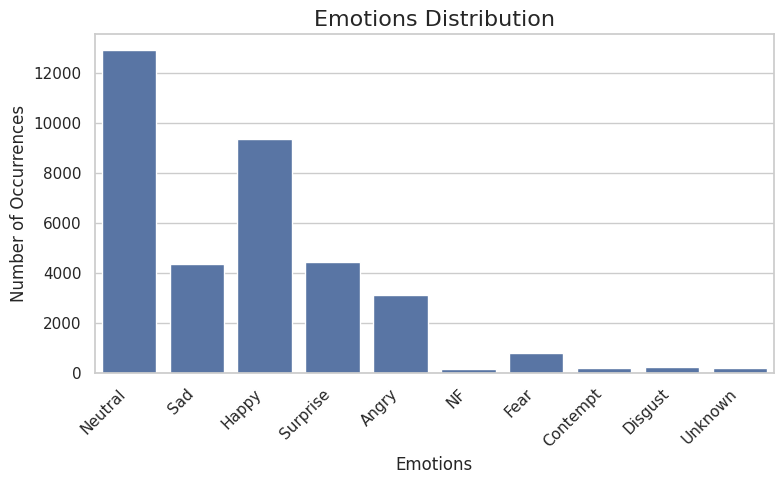

In [ ]:
# Create bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
emotions = ['Neutral', 'Sad', 'Happy', 'Surprise', 'Angry', 'NF', 'Fear', 'Contempt', 'Disgust', 'Unknown']
ax = sns.barplot(x=emotions, y=emotion_counts.Number)
plt.title('Emotions Distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# Split data into Train, Test, and Validation sets
train_df = data.loc[data["Usage"] == "Training"]
validation_df = data.loc[data["Usage"] == "PrivateTest"]
test_df = data.loc[data["Usage"] == "PublicTest"]

print("Training shape = ", train_df.shape)
print("Validation shape = ", validation_df.shape)
print("Testing shape = ", test_df.shape)

Training shape =  (28709, 4)
Validation shape =  (3589, 4)
Testing shape =  (3589, 4)


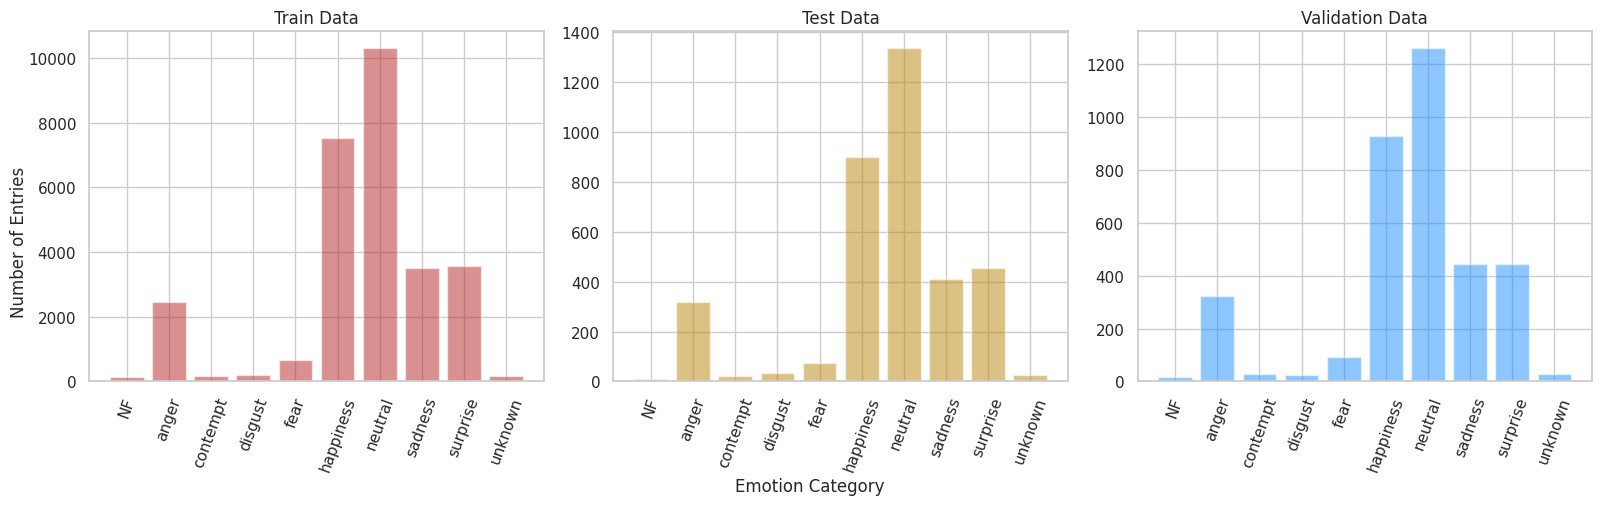

In [ ]:
# Count emotions for each dataset
train_counts = train_df['new_emotion'].value_counts().sort_index()
test_counts = test_df['new_emotion'].value_counts().sort_index()
validation_counts = validation_df['new_emotion'].value_counts().sort_index()

# Plot each distribution in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Train data
axes[0].bar(train_counts.index, train_counts.values, color='firebrick', alpha=0.5)
axes[0].set_title("Train Data")
axes[0].tick_params(axis='x', labelrotation=70)
axes[0].grid(True)

# Test data
axes[1].bar(test_counts.index, test_counts.values, color='darkgoldenrod', alpha=0.5)
axes[1].set_title("Test Data")
axes[1].tick_params(axis='x', labelrotation=70)
axes[1].grid(True)

# Validation data
axes[2].bar(validation_counts.index, validation_counts.values, color='dodgerblue', alpha=0.5)
axes[2].set_title("Validation Data")
axes[2].tick_params(axis='x', labelrotation=70)
axes[2].grid(True)

# Shared x and y label
fig.text(0.5, 0, 'Emotion Category', ha='center')
fig.text(0, 0.5, 'Number of Entries', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

### Insights from Barplot
* The barplot highlights a significant `imbalance` in the dataset, with certain classes containing notably more samples than others. For instance, the "happiness" class boasts 935 samples, while "disgust" is represented by only 248 samples.

* The minority classes are "contemp", "disgust" and "surprise".

* Imbalanced data poses challenges for machine learning models, potentially leading to `bias` towards the majority class and reduced performance. Therefore, it is imperative to address this issue.

### We can tackle the problem in 3 ways:
1. Data augmentation: This involves creating additional examples from the original dataset with slight alterations such as flipping images vertically or horizontally. This will increase the number of images in the underrepresentated classes and yield a more balanced dataset.

2. Class weighting: Assigning higher weights to examples from minority classes can help balance the dataset during training. The implementation of class weighing can be found in this [notebook by fahantandia](https://github.com/farhantandia/Tricks-for-Handling-Imbalanced-Dataset-Image-Classification/blob/main/notebook.ipynb).

3. Oversampling: To balance class distribution in imbalanced datasets by increasing the number of samples in minority classes through synthetic data generation or replication. eg. SMOTE

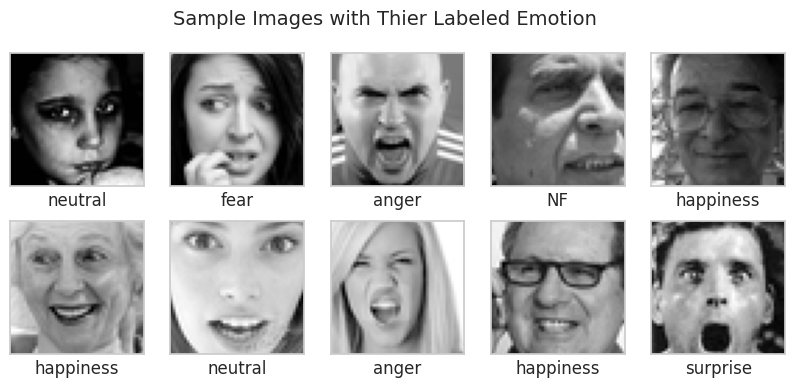

In [ ]:
# Add image and labels into array for display
image_array = []
labels = []
for row in range(20, 30):
    image = np.fromstring(train_df.loc[row, 'pixels'], dtype=int, sep=' ')
    image_array.append(image.flatten())
    labels.append(train_df.loc[row, 'new_emotion'])

# Set figure size to accommodate horizontally arranged images
fig = plt.figure(figsize=(10, 4))

# Loop through the images and print images with labels
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_array[i].reshape(48, 48), cmap='gray')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Add labels below each image
    plt.xlabel(labels[i])

fig.suptitle('Sample Images with Thier Labeled Emotion', fontsize=14)
plt.show()

## ⚙️ Data Preprocessing

In [ ]:
# Print unique emotion labels
print(data['new_emotion'].unique())

['neutral' 'sadness' 'happiness' 'surprise' 'anger' 'NF' 'fear' 'contempt'
 'disgust' 'unknown']


### Remove unuseful data

In [ ]:
# Drop unuseful rows (rows with emotion labelled as NF or unknown)
new_data = data[~data['new_emotion'].isin(['NF', 'unknown'])]
new_data.reset_index(drop=True, inplace=True)

In [ ]:
# Map emotions to numerical values
# Cannot have gap to perform ohe, so by ignoring NF: 5, fear will be 5 instead
# emotion_map = {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'NF': 5, 'fear': 6, 'contempt': 7, 'disgust': 8, 'unknown': 9}
emotion_map = {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'fear': 5, 'contempt': 6, 'disgust': 7}
new_data['new_emotion'] = new_data['new_emotion'].map(emotion_map)
new_data.head()

,emotion,pixels,Usage,new_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,0
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0


### Splitting the Dataset

In [ ]:
# Split data into Train, Test, and Validation sets after cleaning
train_data = new_data.loc[new_data["Usage"] == "Training"]

validation_data = new_data.loc[new_data["Usage"] == "PublicTest"]
validation_data.reset_index(drop=True, inplace=True)

test_data = new_data.loc[new_data["Usage"] == "PrivateTest"]
test_data.reset_index(drop=True, inplace=True)


print("Training shape = ", train_data.shape)
print("Validation shape = ", validation_data.shape)
print("Testing shape = ", test_data.shape)

Training shape =  (28389, 4)
Validation shape =  (3553, 4)
Testing shape =  (3546, 4)


In [ ]:
# Split DataFrame into feature and target arrays for the 3 sets
h = 48
w = 48

n_samples = len(train_data)
X_train = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_train[i] = np.fromstring(train_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_train = np.array(train_data['new_emotion'])

n_samples = len(validation_data)
X_validate = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_validate[i] = np.fromstring(validation_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_validate = np.array(validation_data['new_emotion'])

n_samples = len(test_data)
X_test = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_test[i] = np.fromstring(test_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_test = np.array(test_data['new_emotion'])

### One Hot Encoding of the Labels

* One-hot encoding is required for multi-class classification problem
* After performing one hot encoding, it will generate 8 columns i.e. 8 output neurons for each label.
* {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'fear': 5, 'contempt': 6, 'disgust': 7}

In [ ]:
print(train_data['new_emotion'].unique())

[0 1 2 3 4 5 6 7]


In [ ]:
# Display the shapes of train and test sets before one hot encoding
print("Shape of y_train: " , y_train.shape)
print("Shape of y_validate: ", y_validate.shape)
print("Shape of y_test: ", y_test.shape)

# Perform one-hot encoding
y_cat_train = utils.to_categorical(y_train)
y_cat_validate = utils.to_categorical(y_validate)
y_cat_test = utils.to_categorical(y_test)

# Shapes of train and test sets after one-hot encoding
print("Shape of OHE y_train: " , y_cat_train.shape)
print("Shape of OHE y_validate: ", y_cat_validate.shape)
print("Shape of OHE y_test: ", y_cat_test.shape)

Shape of y_train:  (28389,)
Shape of y_validate:  (3553,)
Shape of y_test:  (3546,)
Shape of OHE y_train:  (28389, 8)
Shape of OHE y_validate:  (3553, 8)
Shape of OHE y_test:  (3546, 8)


In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_validate = X_validate / 255.0
X_test = X_test / 255.0

## 👷 Model Building and Evaluating
![caption](assets/cnn_architecture.png)

Our team has trained a couple of CNN models which has a series of layers:

1. Input Layer: The input images are grayscale images with a single channel.

2. Convolutional Layers: The model consists of several convolutional layers (conv1, conv2, conv3, conv4, conv5, conv6) followed by batch normalization layers (bn1, bn2, bn3) and rectified linear unit (ReLU) activation functions. These layers extract features from the input images by convolving learnable filters over the input image.

3. Pooling Layers: Max-pooling layers (pool) are used to reduce the spatial dimensions of the feature maps, which helps in reducing the computational complexity and controlling overfitting.

4. Dropout Layers: Dropout layers (dropout1, dropout2, dropout3) are added after some convolutional and pooling layers to randomly drop a fraction of the neuron units during training, which helps in regularizing the model and preventing overfitting.

5. Fully Connected Layers: The output of the convolutional layers is flattened and fed into fully connected layers (fc1, fc2) for classification. These layers perform the final classification based on the features extracted by the convolutional layers.

6. Output Layer: The output layer (fc2) produces the final output, which represents the predicted class probabilities. The number of units in this layer is equal to the number of classes in the classification task.

7. Activation Function: The output of the last fully connected layer is passed through a softmax activation function to obtain the predicted probabilities for each class.


In [ ]:
def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model.save('/content/model' + str(test_acc) + '.keras')
    model_json = model.to_json()
    with open('/content/model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('/content/model' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')

# Function to plot loss and accuracy for train and validation set
def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
num_features = 64
batch_size = 64
epochs = 100
width, height = 48, 48
num_labels = 8

### CNN Model 1: Baseline Model
A baseline Convolutional Neural Network (CNN) model is constructed, comprising two main components:

> **1) Front-end Feature Extraction:**
- Each block consists of convolutional layers with small filter sizes of (3,3), containing either 64 or 128 filters, followed by a max pooling layer.
- The resulting feature maps are then flattened to serve as input features for the classifier.

> **2) Back-end Classifier:**
- Responsible for making predictions based on the extracted features.

**Explanation:**
- We opt for `categorical_crossentropy` as our loss function since our task involves a multi-class classification problem.
- sparse_categorical_crossentropy isn't utilized because our labels are one-hot encoded.
- We select the `Adam` optimizer for our baseline model due to its ability to effectively handle sparse gradients on noisy problems. Adam combines the strengths of the AdaGrad and RMSProp algorithms, making it well-suited for training deep learning models.
- Adam serves as a more advanced optimization algorithm compared to stochastic gradient descent, particularly beneficial for training deep neural networks.


In [ ]:
# 1st convolution layer
model1 = Sequential()

# Block one
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train[0].shape)))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 2nd convolution layer
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd convolution layer
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Head
model1.add(Flatten())

# Fully connected neural networks
model1.add(Dense(1024, activation='relu'))

# Output layer
model1.add(Dense(num_labels, activation='softmax'))

# Compiling the model
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,217,800 (8.46 MB)

 Trainable params: 2,217,800 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
h_callback1 = model1.fit(X_train, y_cat_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_validate, y_cat_validate),
                        shuffle=True)

Epoch 1/100
 31/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3233 - loss: 1.7504

I0000 00:00:1713281922.393772      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4224 - loss: 1.5250 - val_accuracy: 0.6262 - val_loss: 1.1120
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6384 - loss: 1.0269 - val_accuracy: 0.6659 - val_loss: 0.9771
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6932 - loss: 0.8645 - val_accuracy: 0.6994 - val_loss: 0.8425
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7369 - loss: 0.7474 - val_accuracy: 0.7107 - val_loss: 0.8286
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7551 - loss: 0.6769 - val_accuracy: 0.7307 - val_loss: 0.7947
Epoch 6/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7891 - loss: 0.5787 - val_accuracy: 0.7368 - val_loss: 0.7627
Epoch 7/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8316 - loss: 0.4726 - val_accuracy: 0.7360 - val_loss: 0.8363
Epoch 8/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8441 - loss: 0.4375 - val_accuracy: 0.74

In [ ]:
# Evaluate model performance on test set
score = model1.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6277 - loss: 7.2556
Loss: 7.1700
Accuracy: 0.6227


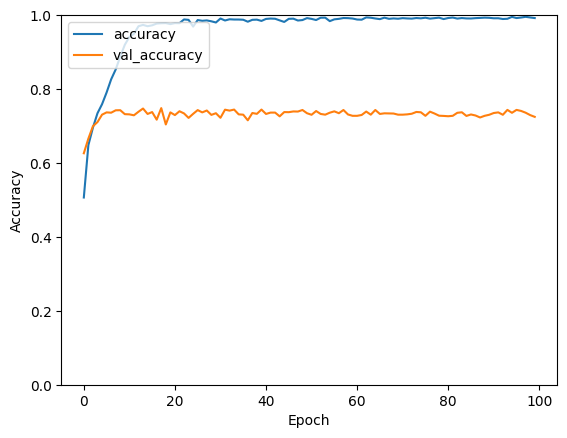

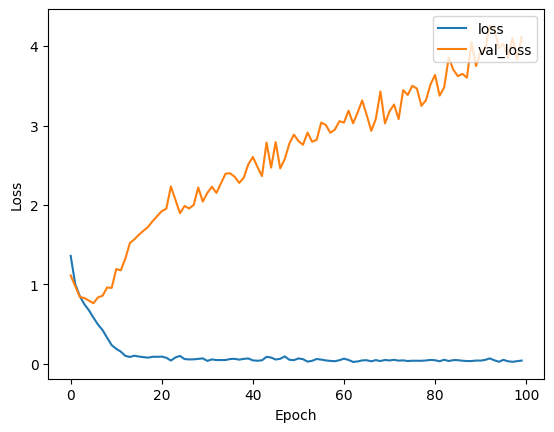

In [ ]:
plot_acc_loss(h_callback1)

In [ ]:
# save_model_and_weights(model1, score)

### Insights
* When evaluating the model on the training data, it demonstrates relatively high accuracy and low loss compared to the validation data, indicating potential `overfitting`.

#### Possible reasons of overfitting
* Insufficient Data: The model may struggle to generalize to unseen data due to a limited number of training examples.
* Limited Variability in Data: If the dataset lacks diversity or variability in terms of classes, features, or viewpoints, the model may struggle to generalize to unseen examples. For instance, if the dataset contains only a few variations of each class or lacks representative samples for certain classes, the CNN may overfit to the available examples.
* Inadequate Regularization: Regularization techniques such as dropout, weight decay, or batch normalization are commonly used to prevent overfitting by introducing constraints on the model's parameters or reducing co-adaptation among neurons. If these regularization techniques are not properly applied or tuned, the CNN may fail to generalize effectively, leading to overfitting.

#### Possible solutions to reduce overfitting
* Data Augmentation: Increase the diversity of the dataset by applying transformations such as rotation, translation, scaling, flipping, or adding noise to the images.
* Regularization Techniques: Dropout: Randomly deactivate a certain percentage of neurons during training to prevent co-adaptation and encourage the network to learn more robust features.
* Early Stopping: Monitor the model's performance on a separate validation set during training and stop training when the performance begins to deteriorate, indicating overfitting.
* Transfer Learning: Utilize pre-trained CNN models trained on large datasets (e.g., ImageNet) and fine-tune them on the specific task with a smaller dataset.
Transfer learning leverages the knowledge learned from the pre-trained model and can lead to better generalization performance, especially when training data is limited.

### CNN Model 2
* Implemented `Batch Normalization` layer to improve training stability and convergence.
* Addressed overfitting concerns by introducing `Dropout layers` after MaxPooling and Dense layers.

#### Benefits of Batch Normalization:
* Batch Normalization adds a normalization layer after every convolutional layer. This helps to `stabilize` the training process by reducing the impact of changes in the data distribution within each batch, known as "covariate shift". By doing this, Batch Normalization makes the model less sensitive to the scale of parameters.
* It also accelerates the model convergence during training, enabling the utilization of higher learning rates for `faster optimization`.

#### Considerations for Dropout Layers:
* Dropout layers induce `information loss`, potentially affecting the network's learning capacity. Start with a conservative dropout rate in the initial layers and gradually increase it.
* It's crucial to strike a balance between regularizing the network to prevent overfitting and preserving sufficient information flow for effective learning across the entire network.

In [ ]:
# 1st Convolution layer
model2 = Sequential()

# Block one
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model2.add(Conv2D(64, kernel_size= (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Dropout(0.5))

# 2nd Convolution layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Dropout(0.5))

# 3rd Convolution layer
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Flatten())

# Fully connected neural networks
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_labels, activation='softmax'))

# Compiling the model
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,917,000 (7.31 MB)

 Trainable params: 1,916,488 (7.31 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Training the model
h_callback2 = model2.fit(X_train, y_cat_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_validate, y_cat_validate),
                        shuffle=True)

Epoch 1/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.3890 - loss: 1.6534 - val_accuracy: 0.4982 - val_loss: 1.6270
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5720 - loss: 1.2100 - val_accuracy: 0.6184 - val_loss: 1.1467
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6322 - loss: 1.0535 - val_accuracy: 0.5198 - val_loss: 1.3748
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6688 - loss: 0.9454 - val_accuracy: 0.6862 - val_loss: 0.8994
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6971 - loss: 0.8643 - val_accuracy: 0.6687 - val_loss: 0.9635
Epoch 6/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7116 - loss: 0.8074 - val_accuracy: 0.7177 - val_loss: 0.8580
Epoch 7/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7307 - loss: 0.7480 - val_accuracy: 0.6941 - val_loss: 0.9197
Epoch 8/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7504 - loss: 0.6954 -

In [ ]:
# Evaluate model performance on test data
score = model2.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7542 - loss: 1.4963
Loss: 1.5083
Accuracy: 0.7518


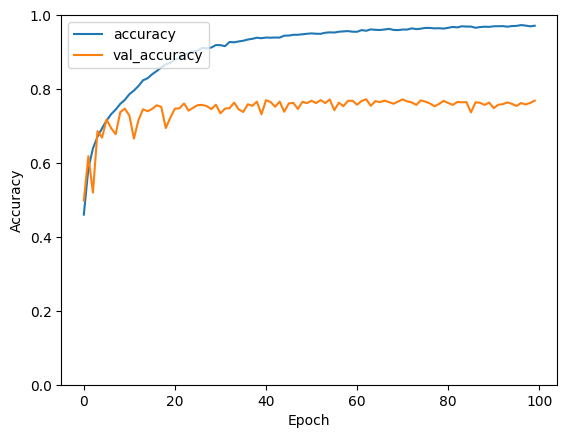

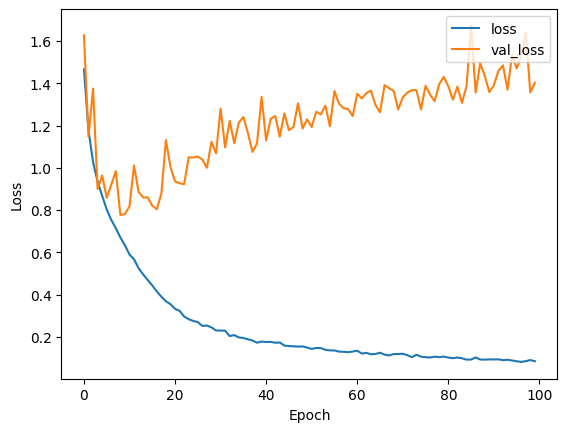

In [ ]:
plot_acc_loss(h_callback2)

In [ ]:
# save_model_and_weights(model2, score[1])

Model and weights are saved in separate files.


### Insights
- We managed to `reduce` the training accuracy `slightly` while achieving a `higher` validation accuracy.
- However, the significant `disparity` between the performance on the training and validation datasets indicates that the `overfitting` issue persists.
- Our next step will involve implementing data augmentation, which will provide the model with a more diverse dataset which will aid the model in `better generalizing` to unseen examples.

### CNN Model 3

#### Data Augementation
- Data augmentation is a technique for enhancing the performance of machine learning models by creating new and diverse examples to augment training datasets. These augmented examples simulate `variations` that the model may encounter in real-world scenarios, thereby improving its ability to `generalize` well beyond the training data.
- By generating additional samples for underrepresented classes, data augmentation helps `balance` the `class distribution`. This prevents the model from favoring the majority class and facilitates better learning of discriminative features for all classes.

In [ ]:
def data_augmentation(X_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(X_train)
    return datagen

In [ ]:
def show_augmented_images(datagen, X_train, y_train):
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}
    it = datagen.flow(X_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # plt.imshow(it.next()[0][0], cmap='gray')
        # label_index = np.argmax(y_train[i][0])
        # emotion_label = reverse_emotion_map[label_index]
        # plt.xlabel(emotion_label)
        # Retrieve and display the image
        batch = it.next()
        image = batch[0][0]
        label_index = np.argmax(batch[1][0])
        plt.imshow(image, cmap='gray')
        emotion_label = reverse_emotion_map[label_index]
        plt.xlabel(emotion_label)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    plt.show()

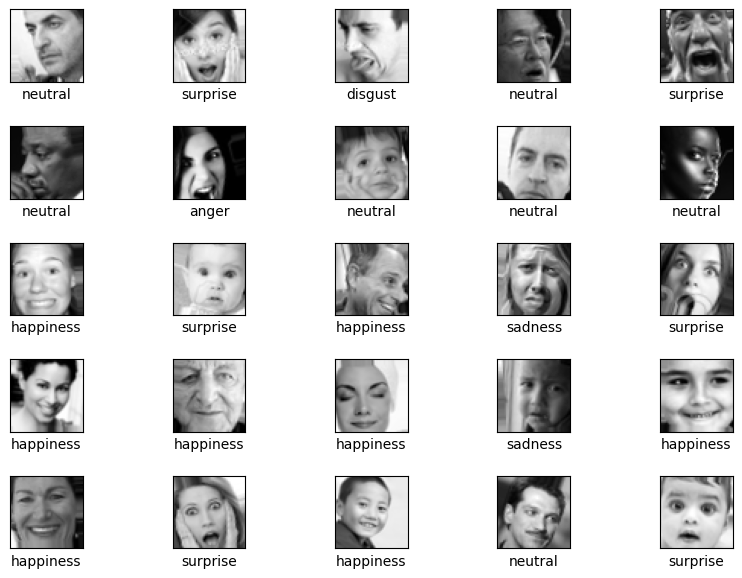

In [ ]:
datagen = data_augmentation(X_train)
show_augmented_images(datagen, X_train, y_cat_train)

In [ ]:
input_shape = (48, 48, 1)
classes = 8
num_features = 64

model3 = Sequential()

# 1st stage
model3.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=X_train.shape[1:]))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Dropout(0.5))

# 2nd stage
model3.add(Conv2D(num_features, (3, 3), activation='relu'))
model3.add(Conv2D(num_features, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd stage
model3.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))

# 4th stage
model3.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model3.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th stage
model3.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))

model3.add(Flatten())

# Fully connected neural networks
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(classes, activation='softmax'))

model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_7 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 44, 44, 64)       

In [ ]:
datagen = data_augmentation(X_train)
epochs = 100
batch_size = 64

In [ ]:
h_callback3 = model3.fit(datagen.flow(X_train, y_cat_train, batch_size=batch_size), epochs=epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=(X_validate, y_cat_validate), verbose=1)

Epoch 1/100
443/443 [==============================] - 41s 65ms/step - loss: 0.3015 - accuracy: 0.4052 - val_loss: 0.3726 - val_accuracy: 0.3757
Epoch 2/100
443/443 [==============================] - 27s 61ms/step - loss: 0.2660 - accuracy: 0.5202 - val_loss: 0.2413 - val_accuracy: 0.5804
Epoch 3/100
443/443 [==============================] - 27s 60ms/step - loss: 0.2387 - accuracy: 0.5775 - val_loss: 0.2204 - val_accuracy: 0.6274
Epoch 4/100
443/443 [==============================] - 27s 61ms/step - loss: 0.2193 - accuracy: 0.6154 - val_loss: 0.1905 - val_accuracy: 0.6800
Epoch 5/100
443/443 [==============================] - 27s 60ms/step - loss: 0.2047 - accuracy: 0.6437 - val_loss: 0.1764 - val_accuracy: 0.7005
Epoch 6/100
443/443 [==============================] - 27s 60ms/step - loss: 0.1936 - accuracy: 0.6661 - val_loss: 0.1703 - val_accuracy: 0.7095
Epoch 7/100
443/443 [==============================] - 26s 59ms/step - loss: 0.1859 - accuracy: 0.6781 - val_loss: 0.1641 - val_ac

In [ ]:
# Evaluate model performance on test data
score = model3.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 [==============================] - 2s 19ms/step - loss: 0.1483 - accuracy: 0.8167
Loss: 0.1483
Accuracy: 0.8167


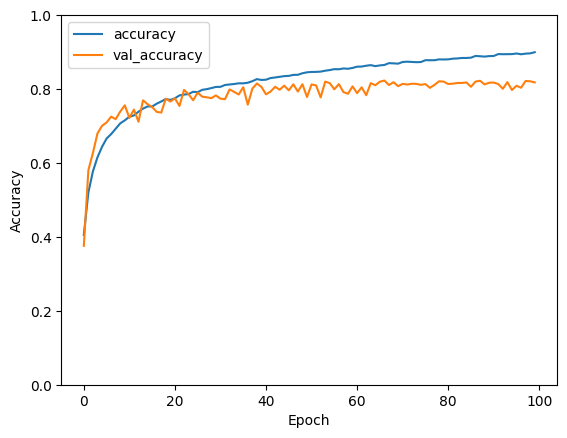

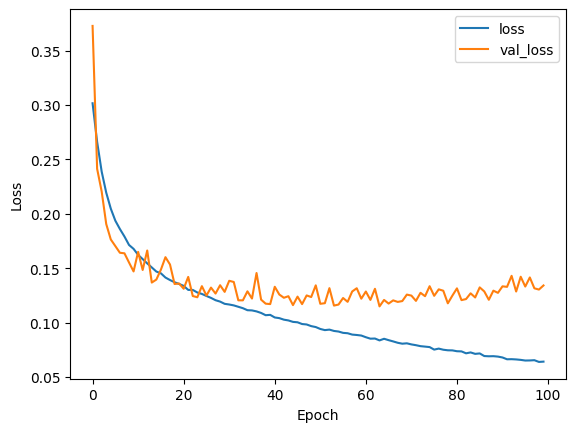

In [ ]:
plot_acc_loss(h_callback3)

In [ ]:
save_model_and_weights(model3, score[1])

Model and weights are saved in separate files.


### Insights
- The model's accuracy on both the training and validation datasets indicates `successful mitigation` of the overfitting issue.
- The model's accuracy on the validation data improves to `0.8179` by the 100th epoch.
- The loss graph reveals a `slight increase` in validation loss during the last 40 epochs.
- Therefore, our team went on to further refining the classification of emotion data. We have adopted a `pretrained model` for the classification task. This approach leverages pre-existing knowledge and expertise to enhance the model's performance.

### Model 4 Pretrained Model: RESNET-50

We chose to use ResNet-50 due to its depth, ability to skip connections, and high performance. ResNet-50 effectively captures complex patterns, mitigates vanishing gradients, and offers state-of-the-art results while being computationally efficient.

Pretrained models are able to leverage on the knowledge and experience of others. They are often trained on large, diverse datasets and thus can recognize a wide range of patterns and features. As a result, ResNet-50 can provide a strong foundation for fine-tuning and significantly improve the performance of the model.

In [ ]:
def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_file_path = '/content/drive/MyDrive/SC1015-Mini-Project-Data/data.zip'   # Path to your zip file
extract_to = '/content/data/'  # Directory where you want to extract the files

# Create the directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_file_path, extract_to)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
base_dir = '/content/data'

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Train",
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22851 images belonging to 8 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Valid",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 713 images belonging to 8 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Test",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 3573 images belonging to 8 classes.


(48, 48, 3)
(1, 48, 48, 3)


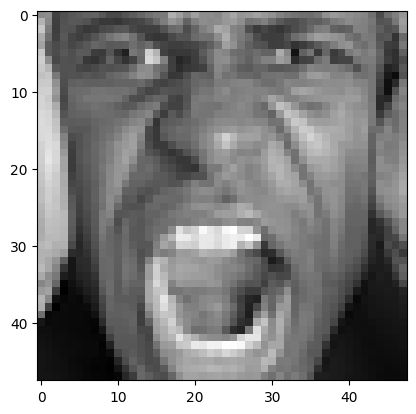

In [ ]:
from keras.preprocessing import image
img = image.load_img(f"{base_dir}/FER2013Test/Anger/fer0032225.png",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [ ]:
# Initialize ResNet50, include_top=False so that only the convolutional base will be used
# the classification layers are excluded
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3), include_top=False, weights="imagenet")

# Freezing Layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Building Model
model4=Sequential()
model4.add(base_model)
model4.add(Dropout(0.5))
model4.add(Flatten())
model4.add(BatchNormalization())
model4.add(Dense(32,kernel_initializer='he_uniform'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32,kernel_initializer='he_uniform'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32,kernel_initializer='he_uniform'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dense(8,activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

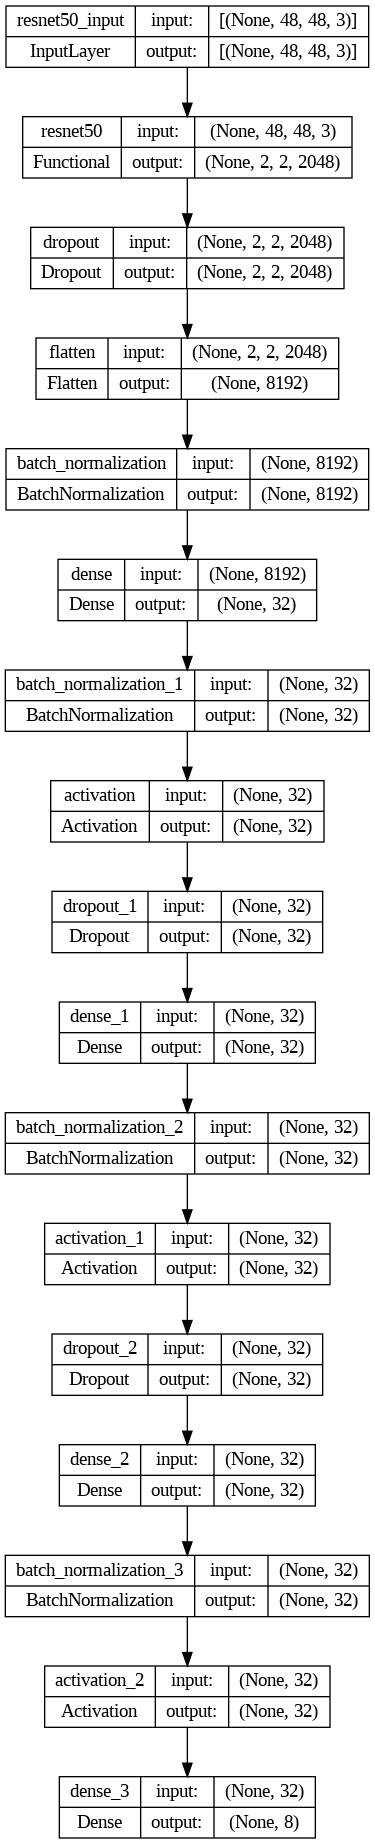

In [ ]:
# display model architecture
plot_model(model4,show_shapes=True,show_layer_names=True)

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
lrd = ReduceLROnPlateau(monitor='val_loss', patience=20,verbose=1, factor=0.50, min_lr=1e-10)
mcp = ModelCheckpoint('/content/model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model4.fit(train_dataset, validation_data=valid_dataset, epochs=60, verbose=1, callbacks=[lrd,mcp,es])

Epoch 1/60
358/358 [==============================] - 50s 106ms/step - loss: 1.8340 - accuracy: 0.8714 - val_loss: 1.6656 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 2/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6410 - accuracy: 0.8735 - val_loss: 1.6229 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 3/60
358/358 [==============================] - 35s 98ms/step - loss: 1.6239 - accuracy: 0.8743 - val_loss: 1.6372 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 4/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6145 - accuracy: 0.8743 - val_loss: 1.6250 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6094 - accuracy: 0.8745 - val_loss: 1.6160 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/60
358/358 [==============================] - 36s 99ms/step - loss: 1.6042 - accuracy: 0.8748 - val_loss: 1.6173 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/60
358/358 [==============================] - 

In [ ]:
# Evaluate model performance on test data
score = model4.evaluate(test_dataset)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

56/56 [==============================] - 3s 43ms/step - loss: 1.5536 - accuracy: 0.8752
Loss: 1.5536
Accuracy: 0.8752


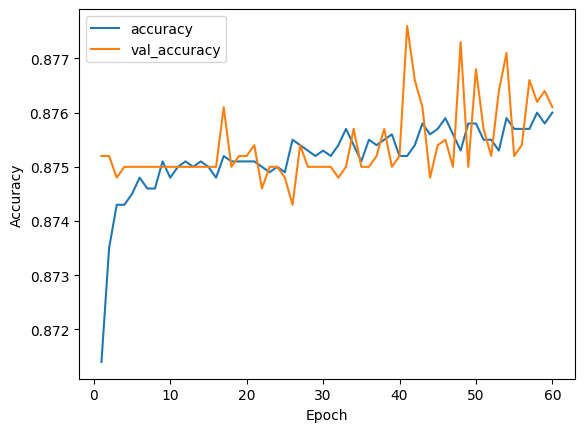

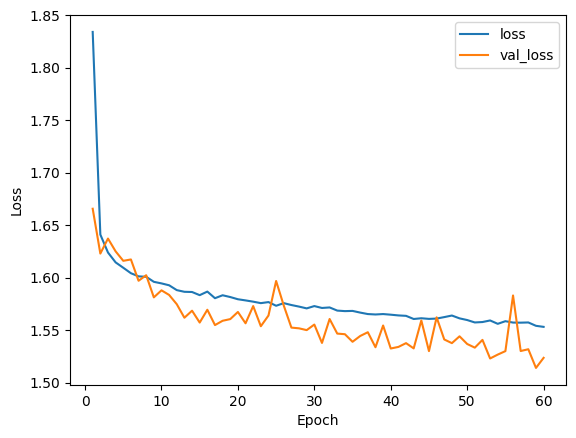

In [ ]:
# Plot training and validation accuracy
plot_acc_loss(history)

### Insights
- At the 60th epoch, the ResNet50 model achieves a training accuracy of `0.8760` and a validation accuracy of `0.8761`.
- This model demonstrates the highest performance among the models created for the emotion detection task.
- The accuracy exhibits `stability` with minimal fluctuations observed.
- Both the loss and validation loss show a `gradual decrease` over epochs, indicating continuous improvement of the model's performance despite the small increments in accuracy during the training.
- The accuracy score on unseen test data is `0.8752` indicates that the model has `generalized well` and is making quite accurate predictions on new data.
- It also indicates that the model is likely `not overfitting` to the training data.
- When a pretrained model reaches a plateau in performance early on and shows very little improvement over subsequent epochs, there are several factors to consider: [to be updated]

## 🔚 Conclusion

In [42]:
img_path = '/content/testImages/'

In [33]:
def load_model(json_path, weights_path):
    with open(json_path, 'r') as json_file:
        model_json = json_file.read()

    model = tf.keras.models.model_from_json(model_json)
    model.load_weights(weights_path)

    return model

def predict_test_images(img_path, model, mode, target_size=(48, 48)):
    image_files = [f for f in os.listdir(img_path)]

    predictions = []

    for image_file in image_files:
        image_path = os.path.join(img_path, image_file)

        img = load_img(image_path, color_mode=mode, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predictions.append(prediction)

    return np.array(predictions)

In [37]:
def plot_emotion_predictions(img_path, predictions):
    image_files = [f for f in os.listdir(img_path)]

    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(img_path, image_file)
        img = load_img(image_path)

        max_index = np.argmax(predictions[i])
        predicted_emotion = [emotion for emotion, index in emotion_dict.items() if index == max_index][0]

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Predicted Emotion: {predicted_emotion}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_probability_distributions(img_path, predictions):
    image_files = [f for f in os.listdir(img_path)]
    plt.figure(figsize=(10, 15))

    for i, image_file in enumerate(image_files):
        plt.subplot(5, 1, i + 1)
        plt.bar(emotion_dict.keys(), predictions[i][0], color='skyblue')
        plt.title(f'Image: {image_file} - Probability Distribution')
        plt.ylabel('Probability')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Model 3

In [3]:
model = load_model('/content/models/Model-3/model8166.json', '/content/models/Model-3/model8166.h5')

In [20]:
predictions = predict_test_images(img_path, model, 'grayscale')

1/1 [==============================] - 0s 39ms/step


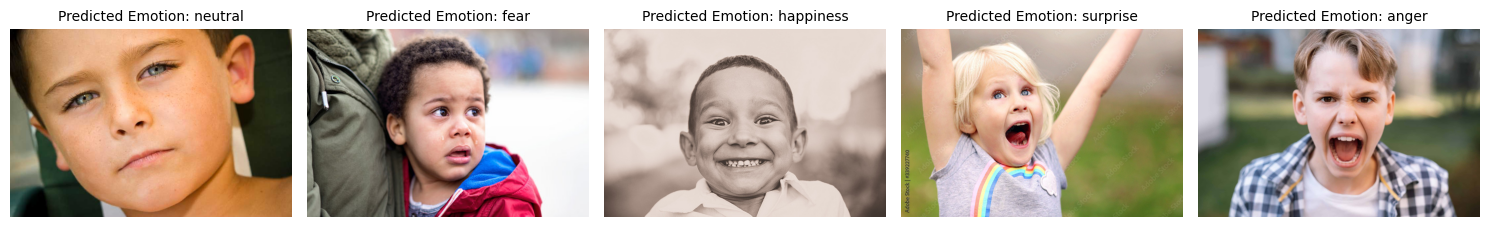

In [32]:
plot_emotion_predictions(img_path, predictions)

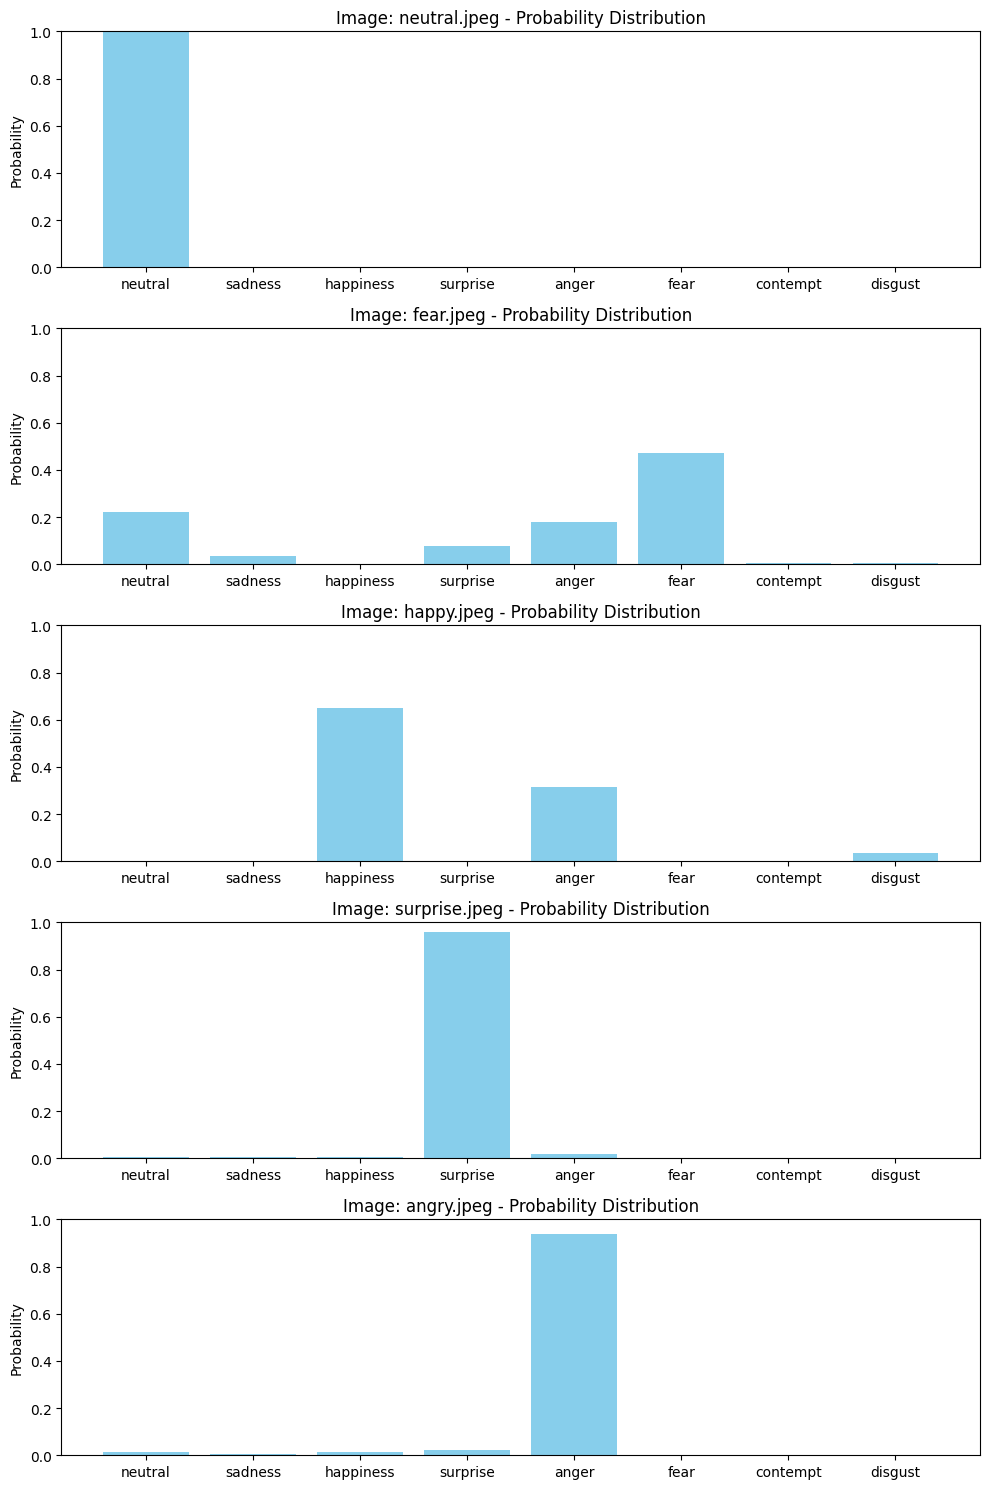

In [38]:
plot_probability_distributions(img_path, predictions)

# ResNet

In [40]:
model = load_model('/content/models/ResNet-50/model8751.json', '/content/models/ResNet-50/model8751.h5')

In [41]:
predictions = predict_test_images(img_path, model, 'rgb')

1/1 [==============================] - 0s 49ms/step


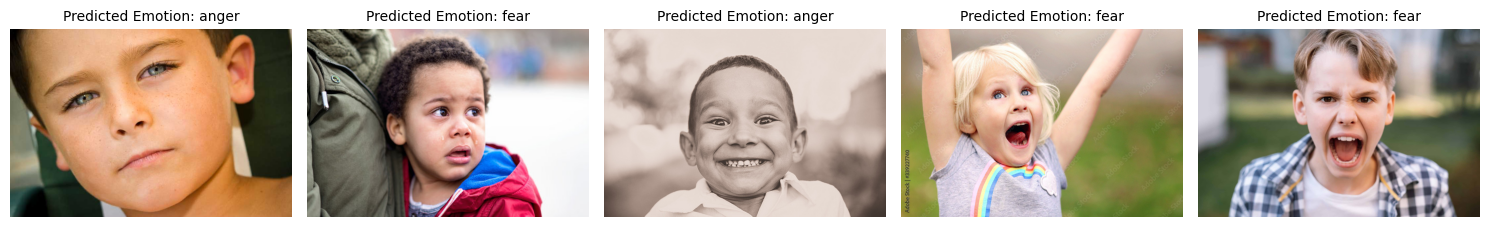

In [43]:
plot_emotion_predictions(img_path, predictions)

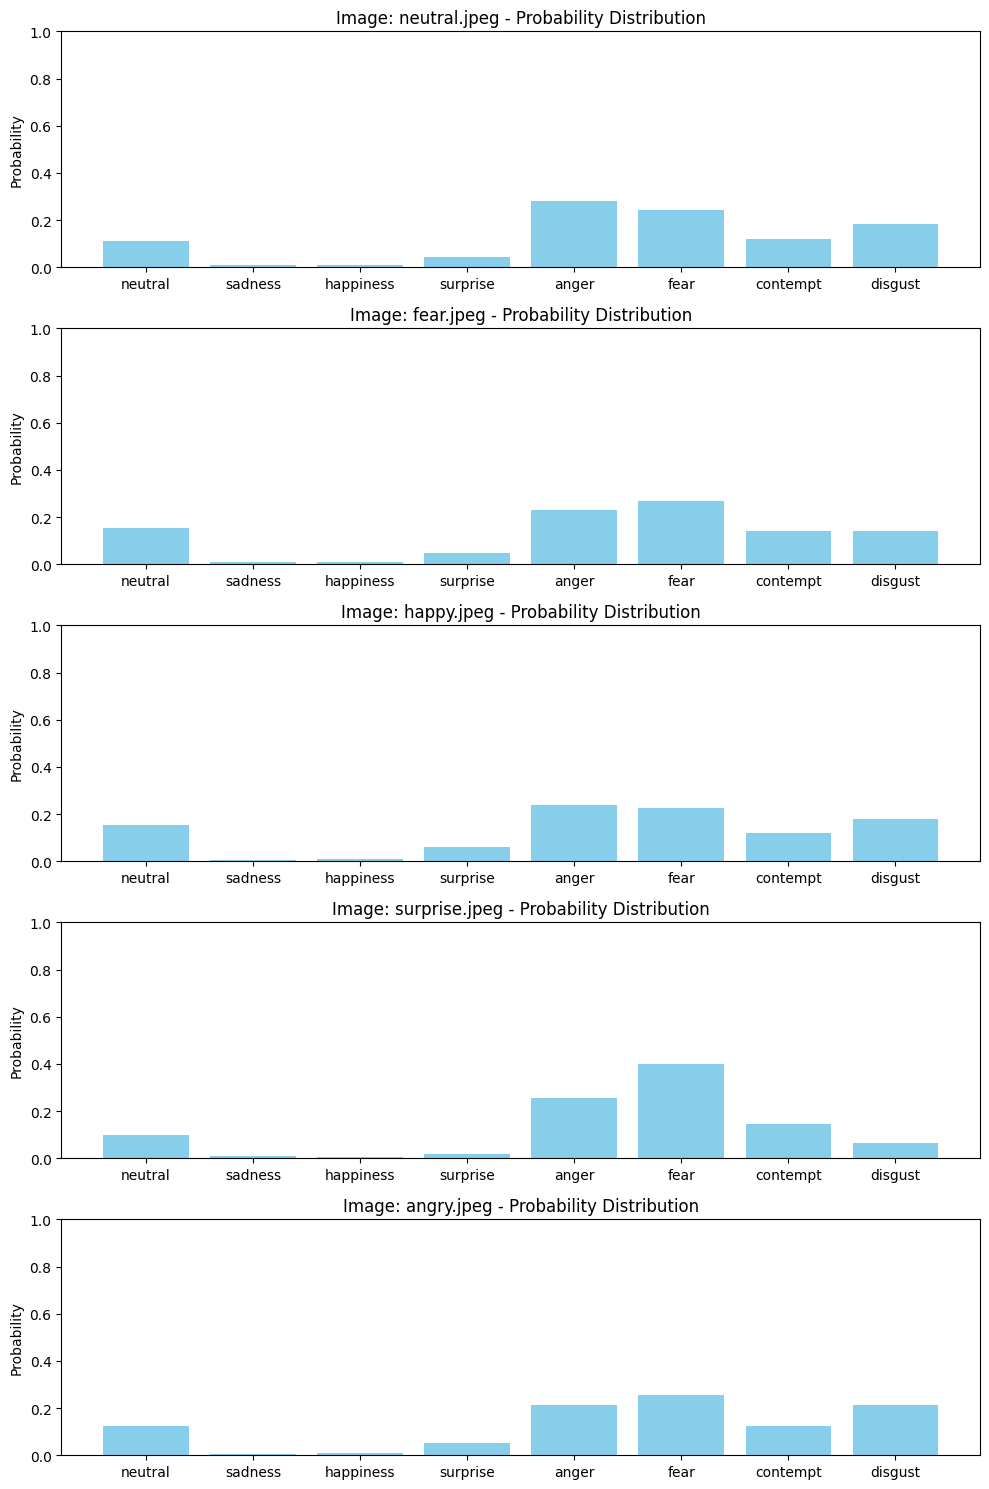

In [44]:
plot_probability_distributions(img_path, predictions)